# **Comparison between the kappa.py and wong.py modules**

This notebook contains a comparison between the modules `kappa.py` and `wong.py`. The `kappa.py` module computes the momentum accumulated by a static parton, assuming that its position is fixed and the momentum changes only by virtue of the electric fields of the Glasma. The `wong.py` module contains the Wong solver for dynamic partons moving through the Glasma. 

## Default simulation parameters for the Glasma and the Wong solvers

In [8]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 10      
N = 512    
tau_sim = 2    
DTS = 8     

# Glasma
su_group = 'su3'
Qs = 2.0        
ns = 50    
factor = 0.8        
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2          	
ir = 0.1 * g**2 * mu         
uv = 10.0           

# Wong
quark = 'charm'     
mass = 1.275     
tau_form = 1/(2*mass)*hbarc   
pT = 0.5    
ntp = 10**5  
nevents = 5    
representation = 'fundamental'      
boundary = 'periodic'
initialization = 'toy'       

# Store relevant parameters in a dictionary
p = {
    'QUARK': quark,
    'MASS': mass,           
    'TFORM': tau_form,       
    'PT': pT,       
    'NTP' : ntp,
    }

## Set environment variables

In [9]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

# Wong modules
from curraun import wong
wong.BOUNDARY = boundary
from curraun.wong import init_pos, init_charge, init_mom_toy

# Kappa module
import curraun.kappa as kappa

import pickle
from tqdm import tqdm

## Simulation routine for evolving the Glasma & solving Wong's equations
Computes the transverse momentum variance.

In [10]:
# Simulation routine
def simulate(p, ev): 
    mass = p['MASS']
    pT = p['PT']
    tau_form = p['TFORM']

    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    formt = int(tau_form / a * DTS)
    maxt = int(tau_sim / a * DTS)

    tau = np.linspace(0, tau_sim, maxt)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize the Wong solver
    wong_solver = wong.WongSolver(s, ntp)
    x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 5)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
    masses = mass / E0 * np.ones(ntp)

    for i in range(ntp):
        x0, p0, q0 = init_pos(s.n), init_mom_toy('pT', pT / E0), init_charge(representation)
        x0s[i, :], p0s[i, :], q0s[i, :] = x0, p0, q0

    wong_solver.initialize(x0s, p0s, q0s, masses)

    # Momentum broadening from the Wong solver
    mom_broad = np.zeros((maxt, 4))

    with tqdm(total=maxt+formt) as pbar:
        for t in range(maxt+formt):
            # Solve Wong's equations
            if t>=formt:  
                # Compute momentum broadening from Wong solver
                mom_broad[t-formt] = wong_solver.p_sq_mean * E0**2
                wong_solver.evolve()
                wong_solver.compute_mom_broad()

            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    return mom_broad, tau

## Running the Wong solver over multiple Glasma events
This is done for various quarks and values of initial transverse momenta, afterwards perform averages and store the results to a dictionary. The masses for charm and beauty quarks are taken from [PDGLive](https://pdglive.lbl.gov/Viewer.action), the formation time is chosen as $\tau_\mathrm{form}=1/(2m_\mathrm{quark})$. 

In [11]:
# quarks = ['charm', 'beauty', 'massive']
# quark_masses = [1.27, 4.18, 1000]
# formation_times = [0.02, 0.08, 0]
quarks = ['beauty', 'charm']
quark_masses = [4.18, 1.27]
# pTs = [0.5, 5.0, 10.0]
pTs = [0, 2, 5, 10]
# formation_times = [0.06, 0.02]

mom_broad, tau = {}, {}
for iq in range(len(quarks)):
    print(quarks[iq].capitalize() + " quark")
    p['QUARK'], p['MASS'] = quarks[iq], quark_masses[iq]
    p['TFORM'] = 1/(2*p['MASS'])*hbarc 
    # p['TFORM'] = formation_times[iq]

    for pT in pTs:
        print('Transverse momentum', pT, 'GeV')
        p['PT'] = pT
        tag = quarks[iq] + '_pT_' + str(pT)
        p['FOLDER'] = su_group + '_pT_' + str(pT) + '_' + quarks[iq] 
        
        # formt, maxt = int(p['TFORM'] / L * N * DTS), int(tau_sim / L * N * DTS)
        # taus = np.linspace(p['TFORM'], tau_sim, maxt-formt)

        mom_broads = []
        for ev in range(nevents):
            mom_broad_ev, tau_wong = simulate(p, ev)
            mom_broads.append(mom_broad_ev)

        mom_broad[tag] = np.mean(mom_broads, axis=0)
        tau[tag] = tau_wong

output = {}
output['quarks'], output['pTs'], output['masses'] = quarks, pTs, quark_masses
output['mom_broad'], output['tau'] = mom_broad, tau
filename = 'mom_broad_wong.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle)

Beauty quark
Transverse momentum 0 GeV


Event 5: 100%|██████████| 828/828 [04:45<00:00,  2.90it/s]


Transverse momentum 2 GeV


Event 5: 100%|██████████| 828/828 [04:25<00:00,  3.12it/s]


Transverse momentum 5 GeV


Event 5: 100%|██████████| 828/828 [04:26<00:00,  3.11it/s]


Transverse momentum 10 GeV


Event 5: 100%|██████████| 828/828 [04:25<00:00,  3.12it/s]


Charm quark
Transverse momentum 0 GeV


Event 5: 100%|██████████| 850/850 [04:29<00:00,  3.16it/s]


Transverse momentum 2 GeV


Event 5: 100%|██████████| 850/850 [04:29<00:00,  3.16it/s]


Transverse momentum 5 GeV


Event 1:  59%|█████▉    | 503/850 [02:37<01:51,  3.11it/s]

## Simulation routine for the static quark case

In [6]:
def simulate_kappa(p, ev): 
    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    formt = int(p['TFORM'] / a * DTS)
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize the Kappa module
    kappa_tforce = kappa.TransportedForce(s)
    mom_broad_kappa, tau_kappa =  [], []

    if use_cuda:
        kappa_tforce.copy_to_device()

    with tqdm(total=maxt+formt) as pbar:
        for t in range(maxt+formt):
            if t>=formt:  
                # Compute momentum broadening from Kappa module
                if t % DTS == 0:
                    if use_cuda:
                        kappa_tforce.copy_mean_to_host()

                    mom_broad_kappa.append(kappa_tforce.p_perp_mean * E0 ** 2)
                    tau_kappa.append((t-formt)*a/DTS)
                    
                    if use_cuda:
                        kappa_tforce.copy_mean_to_device()
                kappa_tforce.compute()

            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    return mom_broad_kappa, tau_kappa

## Run over multiple Glasma events and do averages

In [7]:
# quarks = ['charm', 'beauty', 'massive']
# quark_masses = [1.27, 4.18, 100]
# pTs = [0.5, 5.0, 10.0]
# formation_times = [0.02, 0.08, 0]
quarks = ['beauty', 'charm']
quark_masses = [4.18, 1.27]
pTs = [0.5, 5.0, 10.0]

mom_broad, tau = {}, {}
for iq in range(len(quarks)):
    print(quarks[iq].capitalize() + " quark")
    p['QUARK'], p['MASS'] = quarks[iq], quark_masses[iq]
    p['TFORM'] = 1/(2*p['MASS'])*hbarc
    # p['TOFMR'] = formation_times[iq]

    tag = quarks[iq]
    p['FOLDER'] = su_group + '_kappa_' + quarks[iq] 

    mom_broads = []
    for ev in range(nevents):
        mom_broad_ev, tau[tag] = simulate_kappa(p, ev)
        mom_broads.append(mom_broad_ev)

    mom_broad[tag] = np.mean(mom_broads, axis=0)

output = {}
output['quarks'], output['masses'] = quarks, quark_masses
output['mom_broad'], output['tau'] = mom_broad, tau
filename = 'mom_broad_kappa.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle)

Beauty quark


Event 5: 100%|██████████| 828/828 [02:25<00:00,  5.69it/s]


Charm quark


Event 5: 100%|██████████| 850/850 [02:29<00:00,  5.69it/s]


## Read data from files using Julia

In [1]:
using Pickle

Qs = 2.0
results = ["wong", "kappa"]

function string_as_varname(s::AbstractString,v::Any)
    s=Symbol(s)
    return @eval (($s) = ($v))
end

for r in results
    file = string_as_varname("file_" * r, "mom_broad_" * r * ".pickle")
    data = string_as_varname("data_" * r, Pickle.npyload(file))
    string_as_varname("mom_broad_" * r,  data["mom_broad"])
    string_as_varname("tau_" * r,  data["tau"])
end

quarks = data_wong["quarks"]
pTs = string.(data_wong["pTs"])

4-element Vector{String}:
 "0"
 "2"
 "5"
 "10"

## Plot the results using Makie from Julia

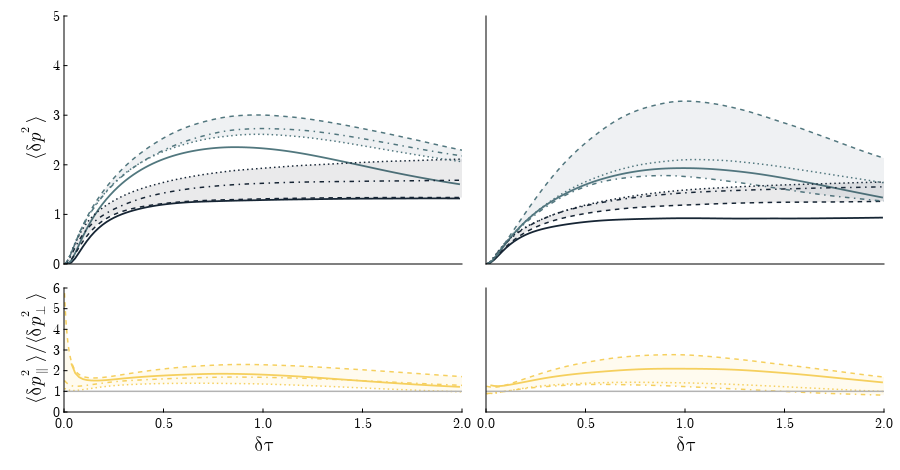

In [10]:
using CairoMakie
using ColorSchemes

segmented_cmap = cgrad(:starrynight, 11, categorical = true)
colors = [segmented_cmap[11], segmented_cmap[4], segmented_cmap[1]]
linestyles = [:dash, :dashdot, :dot]

fig = Figure(resolution = (900, 470), font = "CMU Serif")
axes_up = [Axis(fig[1, i], 
        xlabel=L"\delta\tau", ylabel=L"\langle\delta p^2\,\rangle",
        rightspinevisible = false, topspinevisible = false, xlabelsize = 20, ylabelsize= 20, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4, xgridvisible = false, ygridvisible = false) for i in 1:2]
axes_down = [Axis(fig[2, i], 
        xlabel=L"\delta\tau", ylabel=L"\langle\delta p^2_\parallel\,\rangle/\langle\delta p^2_\perp\,\rangle",
        rightspinevisible = false, topspinevisible = false, xlabelsize = 20, ylabelsize= 20, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4, xgridvisible = false, ygridvisible = false) for i in 1:2]

i = 1
for iq in 1:2
    tag_kappa = quarks[iq]
#     δτ_kappa = Float64.(tau_kappa[tag_kappa].-tau_kappa[tag_kappa][1])
    δτ_kappa = Float64.(tau_kappa[tag_kappa])
    string_as_varname("kappa_T", lines!(axes_up[iq], δτ_kappa, mom_broad_kappa[tag_kappa][:, 1] + mom_broad_kappa[tag_kappa][:, 2], linewidth = 1.8, color=colors[3]))
    string_as_varname("kappa_L", lines!(axes_up[iq], δτ_kappa, mom_broad_kappa[tag_kappa][:, 3], linewidth = 1.8, color=colors[2]))
    ratio = mom_broad_kappa[tag_kappa][:, 3] ./ (mom_broad_kappa[tag_kappa][:, 1] + mom_broad_kappa[tag_kappa][:, 2]) 
    string_as_varname("ratio_kappa", lines!(axes_down[iq], δτ_kappa, ratio , linewidth = 1.8, color=colors[1]))

    for ipT in 1:length(pTs)
        tag_wong = quarks[iq] * "_pT_" * pTs[ipT]
        # δτ_wong = Float64.(tau_wong[tag_wong].-tau_wong[tag_wong][1])
        δτ_wong = Float64.(tau_wong[tag_wong])

        mom_broad_T_wong = (mom_broad_wong[tag_wong][:, 1] + mom_broad_wong[tag_wong][:, 2])
        string_as_varname("linepT"*string(i), lines!(axes_up[iq], δτ_wong, mom_broad_T_wong, linewidth = 1.5, color=colors[3], linestyle=linestyles[ipT]))

        mom_broad_L_wong = mom_broad_wong[tag_wong][:, 3]
        string_as_varname("linepT"*string(i), lines!(axes_up[iq], δτ_wong, mom_broad_L_wong, linewidth = 1.5, color=colors[2], linestyle=linestyles[ipT]))
        i = i+1

        next_tag_wong = quarks[iq] * "_pT_" * pTs[mod(ipT+1, 3)+1]
        next_mom_broad_T_wong = (mom_broad_wong[next_tag_wong][:, 1] + mom_broad_wong[next_tag_wong][:, 2])
        band!(axes_up[iq], δτ_wong, mom_broad_T_wong, next_mom_broad_T_wong; color = (colors[3], 0.05))

        next_mom_broad_L_wong = mom_broad_wong[next_tag_wong][:, 3]
        band!(axes_up[iq], δτ_wong, mom_broad_L_wong, next_mom_broad_L_wong; color = (colors[2], 0.05))

        ratio = mom_broad_L_wong ./ mom_broad_T_wong
        string_as_varname("ratio_wong_"*string(i), lines!(axes_down[iq], δτ_wong, ratio , linewidth = 1.5, color=colors[1], linestyle=linestyles[ipT]))

        next_ratio = next_mom_broad_L_wong ./ next_mom_broad_T_wong
        band!(axes_down[iq], δτ_wong, ratio, next_ratio; color = (colors[1], 0.05))
    end

    tag_wong = quarks[iq] * "_pT_" * pTs[1]
    δτ_wong = Float64.(tau_wong[tag_wong])
    lines!(axes_down[iq], δτ_wong, ones(length(δτ_wong)), linewidth = 1.5, color=:grey70)
end


linkyaxes!(axes_up[1], axes_up[2])
hideydecorations!(axes_up[2], grid = false)
linkyaxes!(axes_down[1], axes_down[2])
hideydecorations!(axes_down[2], grid = false)
for i in 1:2
        linkxaxes!(axes_up[i], axes_down[i])
        hidexdecorations!(axes_up[i], grid = false)
        limits!(axes_up[i], 0, 2, 0, 5)
        limits!(axes_down[i], 0, 2, 0, 6)
end

rowsize!(fig.layout, 1, Relative(2/3))
rowsize!(fig.layout, 2, Relative(1/3))

display(fig)

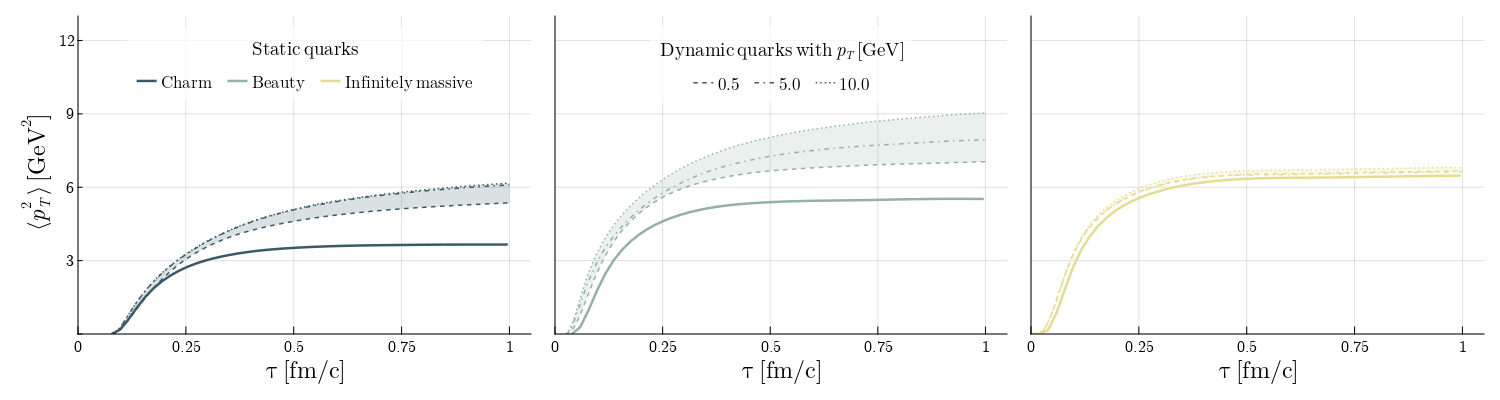

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x000000000af8c9a0, 7500.0, 2000.0)


In [3]:
using CairoMakie
using ColorSchemes

starrynight = cgrad(:starrynight, 11, categorical = true)
colors = [starrynight[3], starrynight[6], starrynight[9]]
linestyles = [:dash, :dashdot, :dot]

fig = Figure(resolution = (1500, 400), font = "CMU Serif")
axes = [Axis(fig[1, i], 
        xlabel=L"\tau\,\mathrm{[fm/c]}", ylabel=L"\langle p_T^2\,\rangle\,\mathrm{[GeV^2]}",
        rightspinevisible = false, topspinevisible = false, xlabelsize = 24, ylabelsize= 24, xticklabelsize=16, yticklabelsize=16,
        xtickalign = 1, xticksize=8, ytickalign=1, yticksize=5,  xlabelpadding = -5) 
     for i in 1:3]

i = 1
for iq in 1:length(quarks)
    for ipT in 1:length(pTs)
        tag_wong = quarks[iq] * "_pT_" * pTs[ipT]
        mom_broad_T_wong = (mom_broad_wong[tag_wong][:, 1] + mom_broad_wong[tag_wong][:, 2])
        string_as_varname("linepT"*string(i), lines!(axes[iq], tau_wong[tag_wong], mom_broad_T_wong, linewidth = 1.5, color=colors[iq], linestyle=linestyles[ipT]))
        i = i+1

        next_tag_wong = quarks[iq] * "_pT_" * pTs[mod(ipT+1, 3)+1]
        next_mom_broad_T_wong = (mom_broad_wong[next_tag_wong][:, 1] + mom_broad_wong[next_tag_wong][:, 2])
        band!(axes[iq], tau_wong[tag_wong], mom_broad_T_wong, next_mom_broad_T_wong; color = (colors[iq], 0.1))
    end
    tag_kappa = quarks[iq]
    mom_broad_T_kappa = (mom_broad_kappa[tag_kappa][:, 1] + mom_broad_kappa[tag_kappa][:, 2])
    string_as_varname("lineq"*string(iq), lines!(axes[iq], Float64.(tau_kappa[tag_kappa]), mom_broad_T_kappa, linewidth = 2.5, color=colors[iq]))

    xlims!(axes[iq], 0, 1.05)
    axes[iq].xticks = (0.25*(0:4), ["0", "0.25", "0.5", "0.75", "1"])
    # Qs = 1.0
    # ylims!(axes[iq], 0, 2.1)
    # axes[iq].yticks = (0.5*(0:4), ["", "0.5", "1", "1.5", "2"])
    # Qs = 2.0
    ylims!(axes[iq], 0, 13)
    axes[iq].yticks = (3*(0:4), ["", "3", "6", "9", "12"])
    # Qs = 3.0
    # ylims!(axes[iq], 0, 19)
    # axes[iq].yticks = (4*(0:4), ["", "4", "8", "12", "16"])

    # ylims!(axes[iq], 0, 9)
    # axes[iq].yticks = (2*(0:4), ["", "2", "4", "6", "8"])
end

linkaxes!(axes[1], axes[2], axes[3])
hideydecorations!(axes[2], grid = false)
hideydecorations!(axes[3], grid = false)
legendq = [L"\mathrm{Charm}", L"\mathrm{Beauty}", L"\mathrm{Infinitely\,massive}"]
axislegend(axes[1], [lineq1, lineq2, lineq3], legendq, L"\mathrm{Static\,quarks}", labelsize=17, titlesize=19,
    position = :ct, orientation = :horizontal, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))
legendpT = [L"0.5", L"5.0", L"10.0"]
axislegend(axes[2], [linepT1, linepT2, linepT3], legendpT, L"\mathrm{Dynamic\,quarks\,with\,}p_T\,\mathrm{[GeV]}", labelsize=17, titlesize=19,
    position = :ct, orientation = :horizontal, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

display(fig)
# save("mom_broad_wong_vs_kappa_qs_" * string(Qs) * ".png", fig, px_per_unit = 5.0) 
save("mom_broad_wong_vs_kappa.png", fig, px_per_unit = 5.0) 